# Linear Regression on Synthetic Time Series Dataset from Week 1:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%202.ipynb

TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2.2.0-rc2


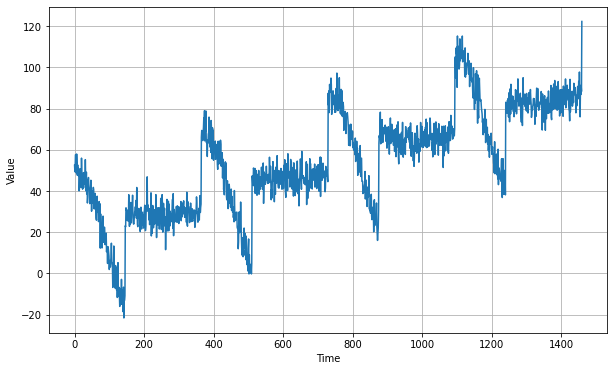

In [0]:
# Creating a synthetic Time Series:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Spliting the data into Training and Validation sets:

time_split = 1000

time_train = time[:time_split]
x_train = series[:time_split]

time_val = time[time_split:]
x_val = series[time_split:]

In [0]:
# Parameters for preparing the dataset ready for ML:

window_size = 20  # window_size is the number of features!
batch_size = 32
shuffle_buffer_size = 1000

In [0]:
# Function to window + capping + flattening + splitting + batching the dataset:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size) :
  dataset = tf.data.Dataset.from_tensor_slices(series)                                # create a tf dataset. we import the time series into tensorflow dataset using from_tensor_slices
  dataset = dataset.window(size=window_size + 1, shift = 1, drop_remainder=True)      # slice the dataset by windows. we add +1 into window_size as the additional one will be used as label!!!
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))              # flatten the data out to be easier to work with. we flatten the data into chuncks of the size of window_size+1
  dataset = dataset.shuffle(shuffle_buffer_size)                                      # once flattened it is easy to shuffle the order of the windows. it picks large dataset by groups of shuffle_buffer_size and then takes random samples. This speeds up the random shuffling in large datasets.
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))                    # splitting the data into features and labels (last one) using map and lambda function. this is stored in tuples.
  dataset = dataset.batch(batch_size).prefetch(1)                                     # the split dataset is batched in batches of the specified size.

  return dataset

In [0]:
# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Setting up the ML model:
# we name the layer as it's easier to retrieve its weights afterwards.
layer0 = tf.keras.layers.Dense(1, activation=None, input_shape=[window_size])   # activation None is the std linear regression (no logit)!!!, input_shape needs to be in array format
model = tf.keras.models.Sequential( [layer0] )

model.summary()

model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 799.1268 - accuracy: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 128.7588 - accuracy: 0.0000e+00
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 101.9850 - accuracy: 0.0000e+00
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 92.3993 - accuracy: 0.0000e+00
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 86.8144 - accuracy: 0.0000e+00
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 83.3863 - accuracy: 0.0000e+00
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 81.0704 - accuracy: 0.0000e+00
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 77.4713 - accuracy: 0.0000e+00
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 75.9829 - accuracy: 0.0000e+00
Epoch 10/100
31/31 [==============================] - 0s 2ms/

In [0]:
# Print out the layer weights:

print('Layer weights: {}' .format(layer0.get_weights()))

Layer weights: [array([[ 0.00376581],
       [ 0.00643104],
       [-0.04598745],
       [-0.02250821],
       [ 0.05957669],
       [ 0.02450737],
       [-0.08113936],
       [ 0.09718863],
       [-0.04817539],
       [ 0.01425413],
       [-0.01966865],
       [ 0.02804554],
       [-0.05954864],
       [ 0.09053409],
       [-0.03874806],
       [ 0.02594705],
       [ 0.02838467],
       [ 0.23748885],
       [ 0.26132852],
       [ 0.42700586]], dtype=float32), array([0.01143302], dtype=float32)]


1441
[array([[43.246246]], dtype=float32), array([[47.491764]], dtype=float32)]


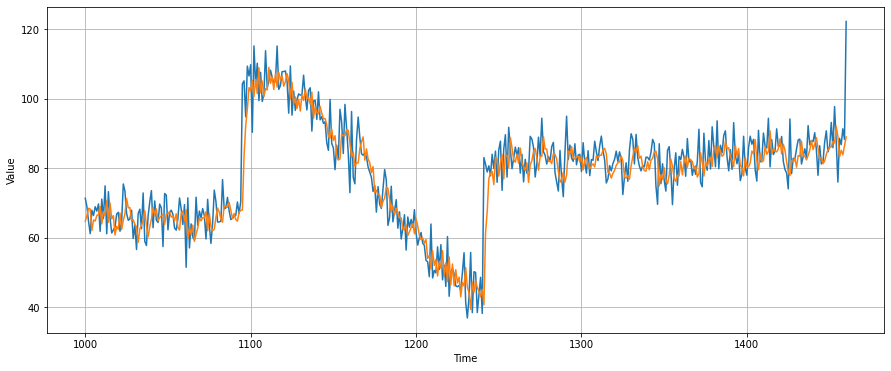

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

45.318886
4.97609
